##### Copyright 2023 The MediaPipe Authors. All Rights Reserved.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Face Landmarks Detection with MediaPipe Tasks

This notebook shows you how to use MediaPipe Tasks Python API to detect face landmarks from images.

## Preparation

Let's start with installing MediaPipe.

In [ ]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 26.5 MB/s eta 0:00:00


Then download the off-the-shelf model bundle(s). Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/face_landmarker#models) for more information about these model bundles.

In [ ]:
!wget -O face_landmarker_v2_with_blendshapes.task -q https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/1/face_landmarker.task

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Visualization utilities

In [ ]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os


def draw_landmarks_on_image(rgb_image, detection_result):
  face_landmarks_list = detection_result.face_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected faces to visualize.
  for idx in range(len(face_landmarks_list)):
    face_landmarks = face_landmarks_list[idx]

    # Draw the face landmarks.
    face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    face_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in face_landmarks
    ])

    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_tesselation_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_contours_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_IRISES,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp.solutions.drawing_styles
          .get_default_face_mesh_iris_connections_style())

  return annotated_image

def plot_face_blendshapes_bar_graph(face_blendshapes):
  # Extract the face blendshapes category names and scores.
  face_blendshapes_names = [face_blendshapes_category.category_name for face_blendshapes_category in face_blendshapes]
  face_blendshapes_scores = [face_blendshapes_category.score for face_blendshapes_category in face_blendshapes]
  # The blendshapes are ordered in decreasing score value.
  face_blendshapes_ranks = range(len(face_blendshapes_names))

  fig, ax = plt.subplots(figsize=(12, 12))
  bar = ax.barh(face_blendshapes_ranks, face_blendshapes_scores, label=[str(x) for x in face_blendshapes_ranks])
  ax.set_yticks(face_blendshapes_ranks, face_blendshapes_names)
  ax.invert_yaxis()

  # Label each bar with values
  for score, patch in zip(face_blendshapes_scores, bar.patches):
    plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{score:.4f}", va="top")

  ax.set_xlabel('Score')
  ax.set_title("Face Blendshapes")
  plt.tight_layout()
  plt.show()

## Download test image

Let's grab a test image that we'll use later. The image is from [Unsplash](https://unsplash.com/photos/mt2fyrdXxzk).

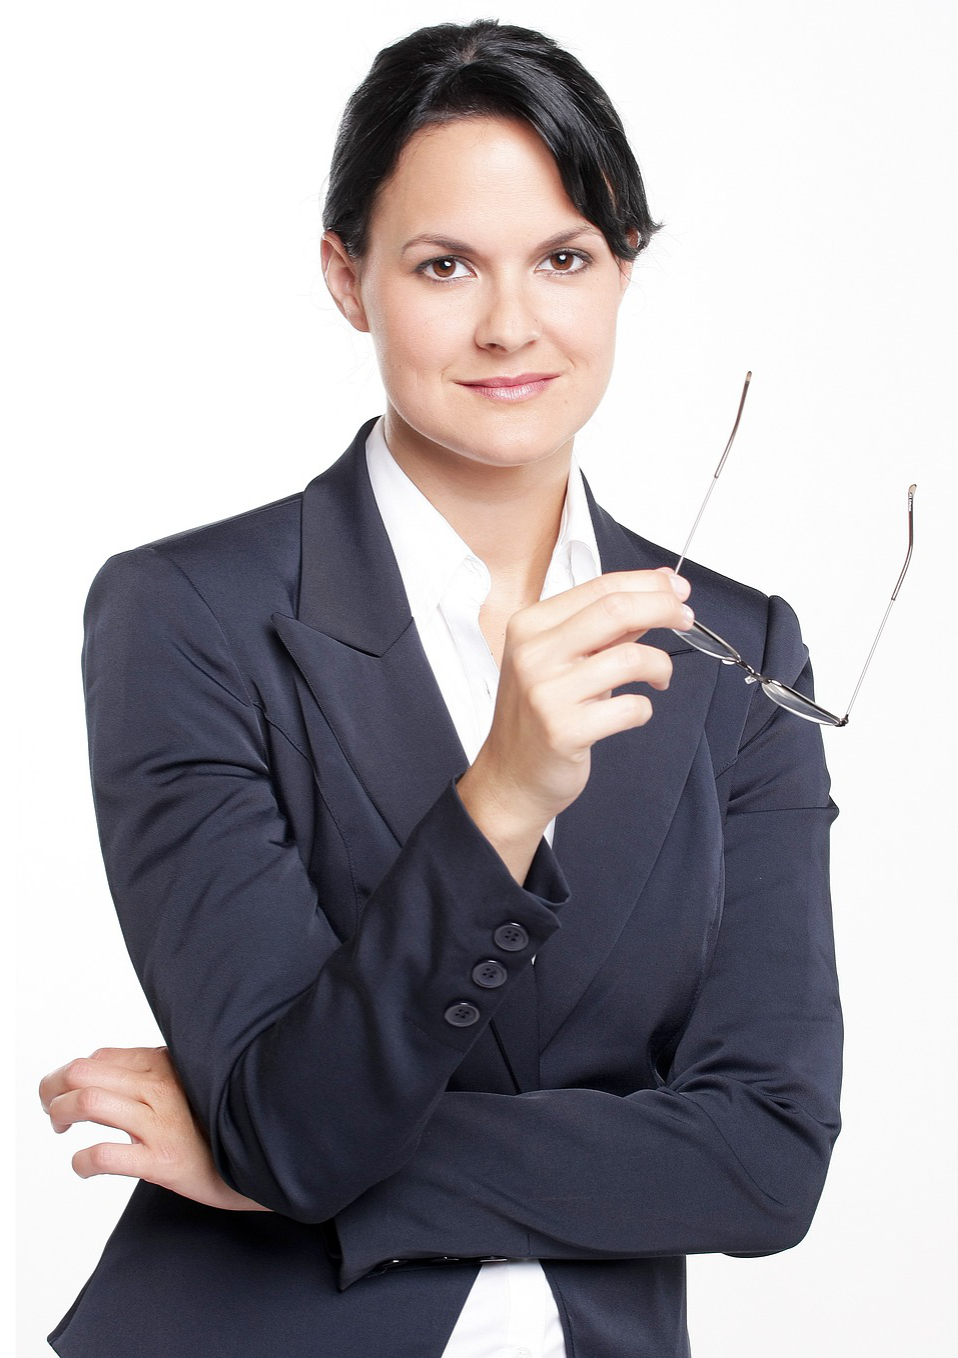

In [ ]:
!wget -q -O image.png https://storage.googleapis.com/mediapipe-assets/business-person.png

import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread("image.png")
cv2_imshow(img)

Optionally, you can upload your own image. If you want to do so, uncomment and run the cell below.

In [ ]:
from google.colab import files
uploaded = files.upload()

for filename in uploaded:
  content = uploaded[filename]
  with open(filename, 'wb') as f:
    f.write(content)

if len(uploaded.keys()):
  IMAGE_FILE = next(iter(uploaded))
  print('Uploaded file:', IMAGE_FILE)

## Running inference and visualizing the results

Here are the steps to run face landmark detection using MediaPipe.

Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/face_landmarker/python) to learn more about configuration options that this task supports.


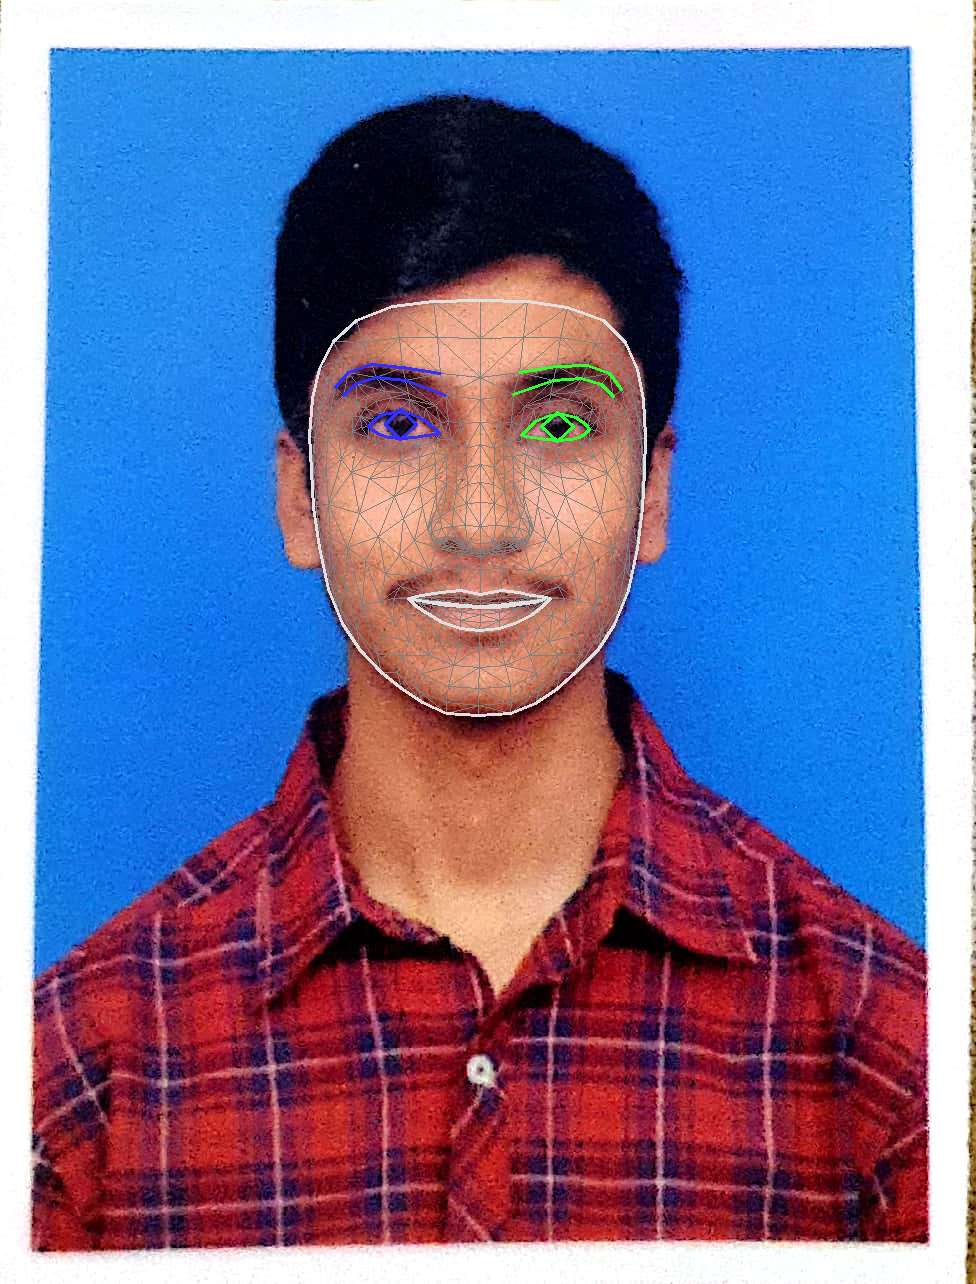

In [ ]:
# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an FaceLandmarker object.
base_options = python.BaseOptions(model_asset_path='face_landmarker_v2_with_blendshapes.task')
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
detector = vision.FaceLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file("/content/drive/MyDrive/Sujith.jpg")

# STEP 4: Detect face landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the detection result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

We will also visualize the face blendshapes categories using a bar graph.

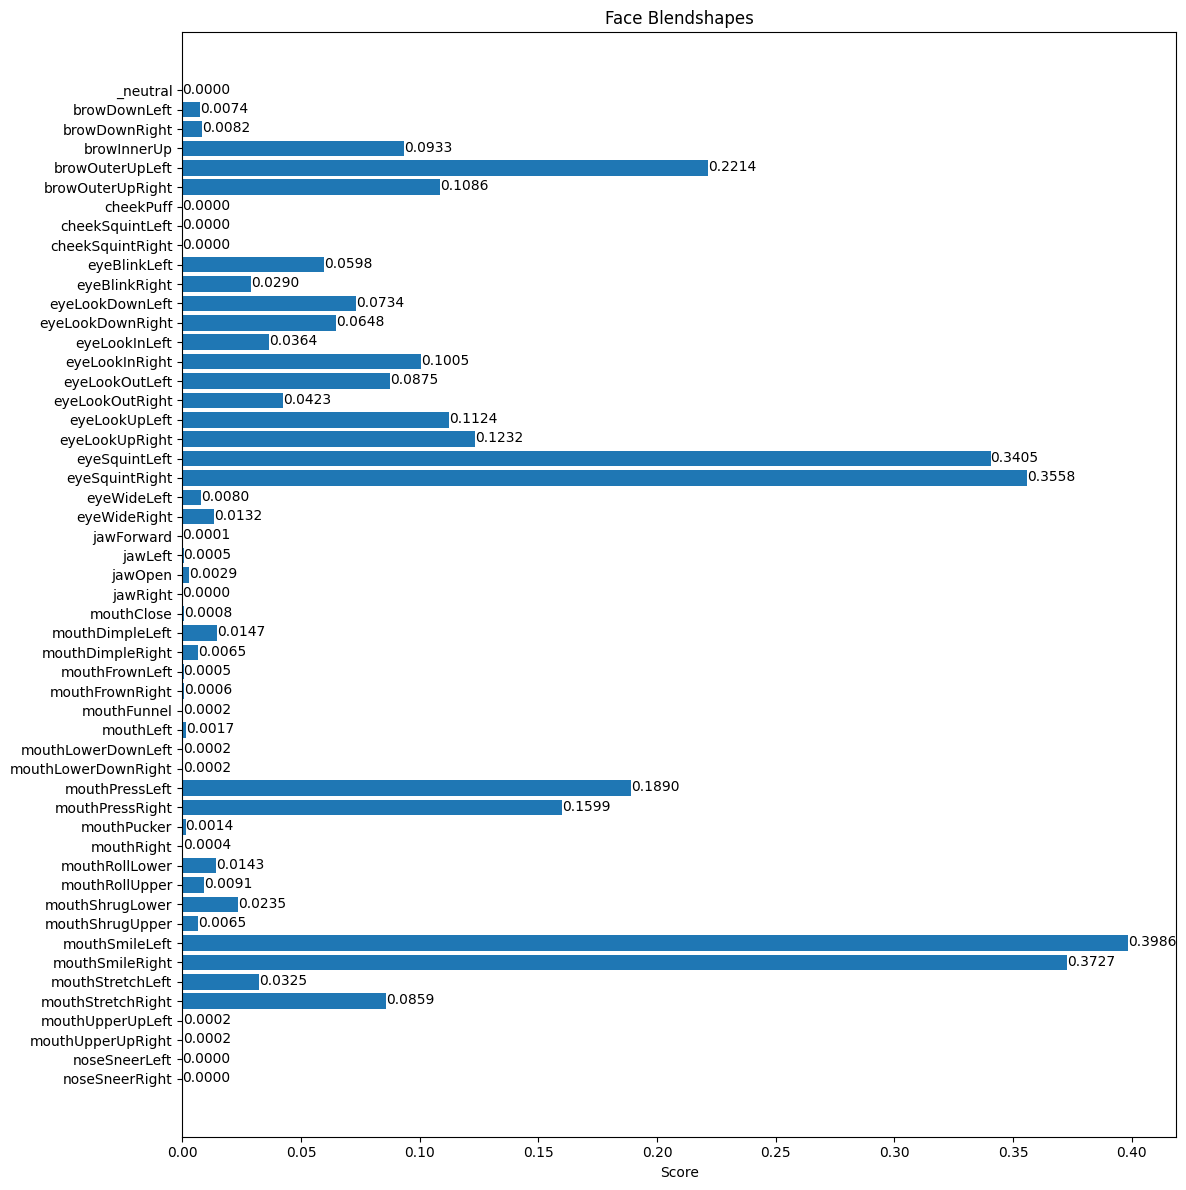

[Category(index=0, score=3.5529812976164976e-06, display_name='', category_name='_neutral'), Category(index=1, score=0.007427658885717392, display_name='', category_name='browDownLeft'), Category(index=2, score=0.008219444192945957, display_name='', category_name='browDownRight'), Category(index=3, score=0.09327254444360733, display_name='', category_name='browInnerUp'), Category(index=4, score=0.22137883305549622, display_name='', category_name='browOuterUpLeft'), Category(index=5, score=0.10857352614402771, display_name='', category_name='browOuterUpRight'), Category(index=6, score=2.8585656764335e-05, display_name='', category_name='cheekPuff'), Category(index=7, score=3.6625777966037276e-07, display_name='', category_name='cheekSquintLeft'), Category(index=8, score=7.06009757323045e-07, display_name='', category_name='cheekSquintRight'), Category(index=9, score=0.059835243970155716, display_name='', category_name='eyeBlinkLeft'), Category(index=10, score=0.02904047816991806, displa

In [ ]:
plot_face_blendshapes_bar_graph(detection_result.face_blendshapes[0])
print(detection_result.face_blendshapes[0])

And print the transformation matrix.

In [ ]:
print(detection_result.facial_transformation_matrixes)

[array([[ 9.99867201e-01,  4.71409084e-03,  1.56112416e-02,
        -3.86657059e-01],
       [-1.84099225e-03,  9.83816445e-01, -1.79169253e-01,
         6.49845314e+00],
       [-1.62032191e-02,  1.79116696e-01,  9.83694375e-01,
        -4.64117470e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])]


In [ ]:
def get_image_features(image_path):
  image_features = []
  image = mp.Image.create_from_file(image_path)
  detection_result = detector.detect(image)
  for category in detection_result.face_blendshapes[0]:
    if(category.category_name != '_neutral'):
      image_features.append(category.score)
  return image_features

## Creating the dataset

In [ ]:
dataset_df = pd.DataFrame()
dataset_dt_df = pd.DataFrame()
labels = ["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]
feature_names = set()
count = 0
can = 0
for label in labels:
  path = f"/content/drive/MyDrive/DFEW/{label}"
  images = [f"{path}/{image}" for image in os.listdir(path)]
  for i, image in enumerate(images):
    if i % 50 == 0:
      print(f"{label} - Images Complete - {i} / {len(images)}")
    try:
      count += 1
      input_image = mp.Image.create_from_file(image)
      detection_result = detector.detect(input_image)
      new_row = {}
      new_dt_row = {}
      for category in detection_result.face_blendshapes[0]:
        if(category.category_name != '_neutral'):
          feature_names.add(category.category_name)
          new_row[category.category_name] = category.score
          new_dt_row[category.category_name] = category.score
      new_row[label] = 1
      new_dt_row['emotion_label'] = label
      df = pd.DataFrame([new_row])
      dt_df = pd.DataFrame([new_dt_row])
      dataset_df = pd.concat([dataset_df, df], ignore_index=True)
      dataset_dt_df = pd.concat([dataset_dt_df, dt_df], ignore_index=True)
    except IndexError:
      can += 1
      continue

  print(f"Processed - {label}")

dataset_df.fillna(0, inplace=True)
dataset_df.to_csv("/content/drive/MyDrive/dataset_unscaled.csv", index=False)
dataset_dt_df.to_csv("/content/drive/MyDrive/dataset_dt_unscaled.csv", index=False)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
def scale_df(df):
  X = df.iloc[:, :-1]
  y = df.iloc[:, -1]
  scaler = MinMaxScaler()
  X_scaled = scaler.fit_transform(X)
  scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
  scaled_df = pd.concat([scaled_df, y], axis=1)
  return scaled_df

In [ ]:
scale_df(dataset_df).to_csv("/content/drive/MyDrive/dataset_scaled.csv", index=False)
scale_df(dataset_dt_df).to_csv("/content/drive/MyDrive/dataset_dt_scaled.csv", index=False)

## Approach 1: Using Decision Tree for Classification

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
data_scaled = pd.read_csv('/content/drive/MyDrive/dataset_dt_scaled.csv')
X = data_scaled.iloc[:, :-1]
y = data_scaled.iloc[:, -1]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [ ]:
y_pred = clf.predict(X_test)

Accuracy: 0.34
              precision    recall  f1-score   support

       Angry       0.30      0.30      0.30       611
     Disgust       0.03      0.03      0.03        37
        Fear       0.12      0.13      0.12       217
       Happy       0.55      0.50      0.52       723
     Neutral       0.38      0.37      0.37       743
         Sad       0.24      0.26      0.25       493
    Surprise       0.29      0.29      0.29       411

    accuracy                           0.34      3235
   macro avg       0.27      0.27      0.27      3235
weighted avg       0.35      0.34      0.34      3235



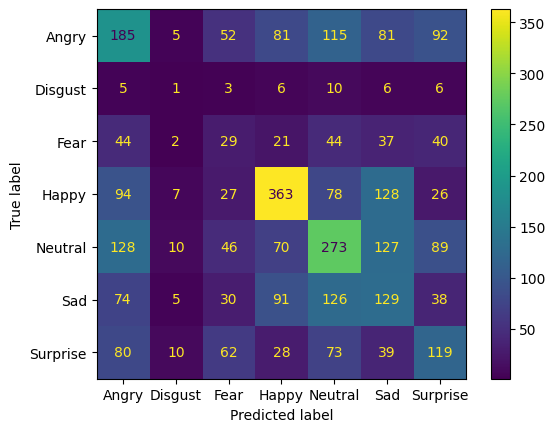

array([0.30278232, 0.02702703, 0.13364055, 0.50207469, 0.36742934,
       0.26166329, 0.28953771])

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

report = classification_report(y_test, y_pred)
print(report)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()

plt.show()
cm.diagonal()/cm.sum(axis=1)

In [ ]:
data_unscaled = pd.read_csv('/content/drive/MyDrive/dataset_dt_unscaled.csv')
X = data_unscaled.iloc[:, :-1]
y = data_unscaled.iloc[:, -1]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [ ]:
y_pred = clf.predict(X_test)

Accuracy: 0.34
              precision    recall  f1-score   support

       Angry       0.31      0.31      0.31       192
     Disgust       0.06      0.08      0.07        12
        Fear       0.15      0.19      0.16        70
       Happy       0.55      0.52      0.54       246
     Neutral       0.34      0.35      0.34       238
         Sad       0.27      0.23      0.25       189
    Surprise       0.25      0.28      0.27       132

    accuracy                           0.34      1079
   macro avg       0.28      0.28      0.28      1079
weighted avg       0.34      0.34      0.34      1079



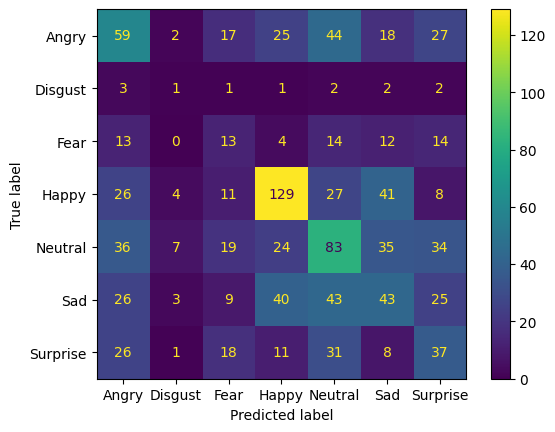

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

report = classification_report(y_test, y_pred)
print(report)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()

plt.show()

In [ ]:
feature_names = ['browDownLeft', 'browDownRight', 'browInnerUp', 'browOuterUpLeft', 'browOuterUpRight', 'cheekPuff', 'cheekSquintLeft', 'cheekSquintRight', 'eyeBlinkLeft', 'eyeBlinkRight', 'eyeLookDownLeft', 'eyeLookDownRight', 'eyeLookInLeft', 'eyeLookInRight', 'eyeLookOutLeft', 'eyeLookOutRight', 'eyeLookUpLeft', 'eyeLookUpRight', 'eyeSquintLeft', 'eyeSquintRight', 'eyeWideLeft', 'eyeWideRight', 'jawForward', 'jawLeft', 'jawOpen', 'jawRight', 'mouthClose', 'mouthDimpleLeft', 'mouthDimpleRight', 'mouthFrownLeft', 'mouthFrownRight', 'mouthFunnel', 'mouthLeft', 'mouthLowerDownLeft', 'mouthLowerDownRight', 'mouthPressLeft', 'mouthPressRight', 'mouthPucker', 'mouthRight', 'mouthRollLower', 'mouthRollUpper', 'mouthShrugLower', 'mouthShrugUpper', 'mouthSmileLeft', 'mouthSmileRight', 'mouthStretchLeft', 'mouthStretchRight', 'mouthUpperUpLeft', 'mouthUpperUpRight', 'noseSneerLeft', 'noseSneerRight']
labels = ["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]

In [ ]:
new_image = get_image_features('/content/drive/MyDrive/disgust_1.jpeg')
new_image_features = pd.DataFrame([new_image], columns=feature_names)
print(clf.predict(new_image_features))

['Neutral']


In [ ]:
text_representation = tree.export_text(clf, feature_names=list(feature_names))
print(text_representation)

|--- mouthSmileRight <= 0.03
|   |--- eyeBlinkLeft <= 0.03
|   |   |--- mouthSmileRight <= 0.00
|   |   |   |--- eyeBlinkRight <= 0.01
|   |   |   |   |--- jawOpen <= 0.40
|   |   |   |   |   |--- jawOpen <= 0.02
|   |   |   |   |   |   |--- eyeSquintRight <= 0.14
|   |   |   |   |   |   |   |--- mouthShrugLower <= 0.33
|   |   |   |   |   |   |   |   |--- cheekSquintRight <= 0.00
|   |   |   |   |   |   |   |   |   |--- jawRight <= 0.00
|   |   |   |   |   |   |   |   |   |   |--- mouthRollUpper <= 0.06
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 18
|   |   |   |   |   |   |   |   |   |   |--- mouthRollUpper >  0.06
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 4
|   |   |   |   |   |   |   |   |   |--- jawRight >  0.00
|   |   |   |   |   |   |   |   |   |   |--- mouthDimpleLeft <= 0.00
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |   |--- mouthDimpleLeft > 

In [ ]:
with open("decistion_tree.log", "w") as fout:
    fout.write(text_representation)

In [ ]:
import graphviz
# DOT data
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=list(feature_names),
                                class_names=list(labels),
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png")
graph.render("decision_tree_graphivz")
graph

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.174051 to fit


## Approach 2: Ripper to generate rules

Generating rules using for each emotion separately

In [ ]:
!pip install wittgenstein

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.6/110.6 kB 1.4 MB/s eta 0:00:00


In [ ]:
import wittgenstein as lw

In [ ]:
def get_rules(ruleset, emotion):
  rules_df = pd.DataFrame()
  ruleset = ruleset.split('V')
  for i in range(len(ruleset)):
    rules = {}
    ruleset[i] = ruleset[i].strip().replace('[','').replace(']','')
    ruleset[i] = ruleset[i].split('^')
    for j in range(len(ruleset[i])):
      ruleset[i][j] = ruleset[i][j].split('=')[0]
    rules['antecedent'] = ', '.join(ruleset[i])
    rules['consequent'] = emotion
    df = pd.DataFrame([rules])
    rules_df = pd.concat([rules_df, df], ignore_index=True)
  return rules_df

In [ ]:
from sklearn.metrics import precision_score, recall_score, roc_curve, auc, RocCurveDisplay
def generate_ripper_rules_and_metrics(labels, data):
  rules_df = pd.DataFrame()
  accuracy = {}
  precision = {}
  recall = {}
  classifiers = {}
  X_train_dict = {}
  X_test_dict = {}
  y_train_dict = {}
  y_test_dict = {}
  for emotion in labels:
    selected_columns = data.columns[:51].tolist() + [emotion]
    df_ripper = data[selected_columns]
    X = df_ripper.iloc[:, :-1]
    y = df_ripper.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    ripper_clf = lw.RIPPER() # Or irep_clf = lw.IREP() to build a model using IREP
    ripper_clf.fit(X_train, y_train, class_feat=emotion, pos_class=1)
    df = get_rules(str(ripper_clf.ruleset_), emotion)
    rules_df = pd.concat([rules_df, df], ignore_index=True)
    classifiers[emotion] = ripper_clf
    accuracy[emotion] = ripper_clf.score(X_test, y_test)
    precision[emotion] = ripper_clf.score(X_test, y_test, precision_score)
    recall[emotion] = ripper_clf.score(X_test, y_test, recall_score)
    X_train_dict[emotion] = X_train
    X_test_dict[emotion] = X_test
    y_train_dict[emotion] = y_train
    y_test_dict[emotion] = y_test
  return rules_df, classifiers, accuracy, precision, recall, X_train_dict, X_test_dict, y_train_dict, y_test_dict

In [ ]:
data_unscaled = pd.read_csv('/content/drive/MyDrive/dataset_unscaled.csv')
rules_unscaled, classifiers_unscaled, accuracy_unscaled, precision_unscaled, recall_unscaled, X_train_dict_unscaled, X_test_dict_unscaled, y_train_dict_unscaled, y_test_dict_unscaled = generate_ripper_rules_and_metrics(labels, data_unscaled)

In [ ]:
print('For Unscaled data')
print(f'accuracy: {accuracy_unscaled}')
print(f'precision: {precision_unscaled}')
print(f'recall: {recall_unscaled}')

For Unscaled data
accuracy: {'Angry': 0.8089644513137558, 'Disgust': 0.9845440494590417, 'Fear': 0.9301391035548686, 'Happy': 0.8389489953632149, 'Neutral': 0.7675425038639876, 'Sad': 0.8435857805255024, 'Surprise': 0.874806800618238}
precision: {'Angry': 0.43859649122807015, 'Disgust': 0.0, 'Fear': 0.2, 'Happy': 0.7167381974248928, 'Neutral': 0.3333333333333333, 'Sad': 0.3142857142857143, 'Surprise': 0.5576923076923077}
recall: {'Angry': 0.04091653027823241, 'Disgust': 0.0, 'Fear': 0.013824884792626729, 'Happy': 0.46196403872752423, 'Neutral': 0.012113055181695828, 'Sad': 0.02231237322515213, 'Surprise': 0.0705596107055961}


In [ ]:
rules_unscaled.to_csv("/content/drive/MyDrive/unscaled_data_rules_ripper.csv", index=False)

In [ ]:
data_scaled = pd.read_csv('/content/drive/MyDrive/dataset_scaled.csv')
rules_scaled, classifiers_scaled, accuracy_scaled, precision_scaled, recall_scaled, X_train_dict_scaled, X_test_dict_scaled, y_train_dict_scaled, y_test_dict_scaled = generate_ripper_rules_and_metrics(labels, data_scaled)

In [ ]:
print('For Scaled data')
print(f'accuracy: {accuracy_scaled}')
print(f'precision: {precision_scaled}')
print(f'recall: {recall_scaled}')

For Scaled data
accuracy: {'Angry': 0.8098918083462133, 'Disgust': 0.9879443585780525, 'Fear': 0.9295208655332303, 'Happy': 0.8404945904173107, 'Neutral': 0.7712519319938176, 'Sad': 0.8472952086553323, 'Surprise': 0.871097372488408}
precision: {'Angry': 0.46774193548387094, 'Disgust': 0.0, 'Fear': 0.21052631578947367, 'Happy': 0.6920222634508348, 'Neutral': 0.5194805194805194, 'Sad': 0.4827586206896552, 'Surprise': 0.47619047619047616}
recall: {'Angry': 0.04746317512274959, 'Disgust': 0.0, 'Fear': 0.018433179723502304, 'Happy': 0.5159059474412172, 'Neutral': 0.05383580080753701, 'Sad': 0.028397565922920892, 'Surprise': 0.145985401459854}


In [ ]:
rules_scaled.to_csv("/content/drive/MyDrive/scaled_data_rules_ripper.csv", index=False)

In [ ]:
def predict_emotion_with_rules(classifier, labels, new_image_features):
  predicted_emotions = []
  for emotion in labels:
    if classifier[emotion].predict(new_image_features)[0]:
      predicted_emotions.append(emotion)
  return predicted_emotions

In [ ]:
image_path = '/content/drive/MyDrive/Sujith.jpg'
features = get_image_features(image_path)
new_image_features = pd.DataFrame([features], columns=feature_names)

In [ ]:
emotion_predictions_unscaled_rules = predict_emotion_with_rules(classifiers_unscaled, labels, new_image_features)
emotion_predictions_unscaled_rules

[]

In [ ]:
emotion_predictions_scaled_rules = predict_emotion_with_rules(classifiers_scaled, labels, new_image_features)
emotion_predictions_scaled_rules

['Happy']

In [ ]:
def get_prominent_features(image_path):
  prominent_image_features = []
  mediapipe_probability_values = []
  image = mp.Image.create_from_file(image_path)
  detection_result = detector.detect(image)
  for category in detection_result.face_blendshapes[0]:
    if category.category_name != '_neutral':
      mediapipe_probability_values.append(category.score)
  q1 = np.percentile(mediapipe_probability_values, 25)
  q3 = np.percentile(mediapipe_probability_values, 75)
  iqr = q3 - q1
  for category in detection_result.face_blendshapes[0]:
    if category.category_name != '_neutral':
      if category.score >= iqr:
        prominent_image_features.append(category.category_name)
  return prominent_image_features

In [ ]:
def find_most_common_row(input_path, rules):
  prominent_features = get_prominent_features(input_path)
  max_common_ratio = 0
  most_common_row = None
  for index, row in rules.iterrows():
    antecedent_set = set(row['antecedent'].split(','))
    # print(set(prominent_features))
    # print(antecedent_set)
    # print(set(prominent_features).intersection(antecedent_set))
    common_ratio = len(set(prominent_features).intersection(antecedent_set))/len(antecedent_set)
    # print(common_ratio)
    if common_ratio >= max_common_ratio:
      max_common_ratio = common_ratio
      most_common_row = row
  return most_common_row, max_common_ratio

In [ ]:
result_row, common_ratio = find_most_common_row('/content/drive/MyDrive/s_sad.jpeg', rules_unscaled)
print(f"Rule Enforced: {result_row['antecedent']} -> {result_row['consequent']}")
print(f"Emotion Classified: {result_row['consequent']}")
print(f"Probability Value: {common_ratio}")

Rule Enforced: eyeSquintRight, mouthStretchLeft, eyeLookOutRight -> Surprise
Emotion Classified: Surprise
Probability Value: 0.3333333333333333


In [ ]:
result_row, common_ratio = find_most_common_row('/content/drive/MyDrive/s_sad.jpeg', rules_scaled)
print(f"Rule Enforced: {result_row['antecedent']} -> {result_row['consequent']}")
print(f"Emotion Classified: {result_row['consequent']}")
print(f"Probability Value: {common_ratio}")

Rule Enforced: eyeBlinkLeft, mouthSmileLeft -> Surprise
Emotion Classified: Surprise
Probability Value: 0.5


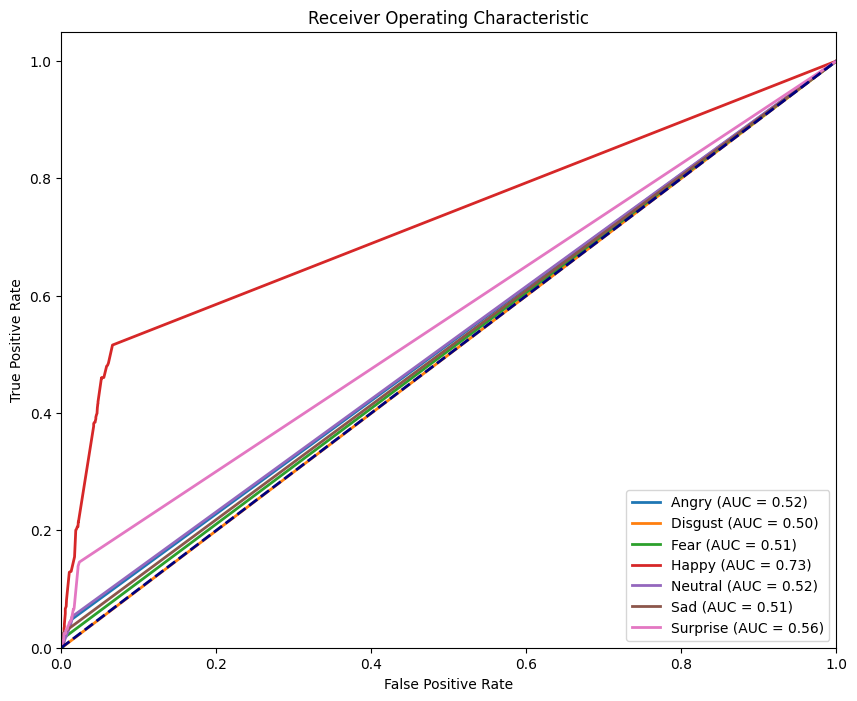

In [ ]:
predictions = {}
plt.figure(figsize=(10, 8))
for i, emotion in enumerate(labels):
  predictions[emotion] = classifiers_scaled[emotion].predict_proba(X_test_dict_scaled[emotion])[:, 1]
  fpr, tpr, thresholds = roc_curve(y_test_dict_scaled[emotion], predictions[emotion])
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, lw=2, label=f'{emotion} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Approach 3: Apriori

In [ ]:
from mlxtend.frequent_patterns import apriori, association_rules

In [ ]:
data_scaled = pd.read_csv('/content/drive/MyDrive/dataset_scaled.csv')
X = data_scaled.drop(columns=labels)
y = data_scaled[labels]
X_encoded = (X >= 0.5).astype(int)
encoded_scaled_df = pd.DataFrame(X_encoded, columns=X.columns)
df_apriori_scaled = pd.concat([encoded_scaled_df, y], axis=1)
df_apriori_scaled.to_csv('/content/drive/MyDrive/dataset_apriori_scaled.csv', index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
data_unscaled = pd.read_csv('/content/drive/MyDrive/dataset_unscaled.csv')
X = data_unscaled.drop(columns=labels)
y = data_unscaled[labels]
X_encoded = (X >= 0.5).astype(int)
encoded_unscaled_df = pd.DataFrame(X_encoded, columns=X.columns)
df_apriori_unscaled = pd.concat([encoded_unscaled_df, y], axis=1)
df_apriori_unscaled.to_csv('/content/drive/MyDrive/dataset_apriori_unscaled.csv', index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
frq_items_scaled = apriori(df_apriori_scaled, min_support = 0.05, use_colnames = True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [ ]:
def filter_df(row):
  truth_value = False
  if len(row['consequents']) == 1:
    for consequent in row['consequents']:
      if consequent in labels:
        truth_value = True
  return truth_value

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
apriori_rules_scaled = association_rules(frq_items_scaled, metric ="lift", min_threshold = 1)
apriori_rules_scaled = apriori_rules_scaled.sort_values(['confidence', 'lift'], ascending =[False, False])
filtered_apriori_rules_scaled = apriori_rules_scaled[apriori_rules_scaled.apply(filter_df, axis=1)]
filtered_apriori_rules_scaled

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


antecedents consequents  antecedent support  \
84  (mouthSmileRight, mouthSmileLeft)     (Happy)            0.082545   
50                   (mouthSmileLeft)     (Happy)            0.096272   
52                  (mouthSmileRight)     (Happy)            0.092562   
73    (eyeSquintRight, eyeSquintLeft)     (Happy)            0.201911   
35                    (eyeSquintLeft)     (Happy)            0.368114   
42                   (eyeSquintRight)     (Happy)            0.273048   
45                   (eyeSquintRight)   (Neutral)            0.273048   
37                    (eyeSquintLeft)   (Neutral)            0.368114   
6                   (browOuterUpLeft)     (Happy)            0.228622   
47                   (eyeSquintRight)       (Sad)            0.273048   
39                    (eyeSquintLeft)       (Sad)            0.368114   

    consequent support   support  confidence      lift  leverage  conviction  \
84            0.213133  0.063346    0.767416  3.600642  0.045753    3.383148   
50            0.213133  0.073085    0.759152  3.561871  0.052566    3.267072   
52            0.213133  0.069004    0.745491  3.497774  0.049276    3.091706   
73            0.213133  0.060471    0.299495  1.405201  0.017437    1.123285   
35            0.213133  0.103599    0.281431  1.320448  0.025141    1.095047   
42            0.213133  0.076424    0.279891  1.313224  0.018228    1.092706   
45            0.229920  0.066036    0.241848  1.051877  0.003257    1.015732   
37            0.229920  0.087275    0.237087  1.031173  0.002638    1.009395   
6             0.213133  0.052309    0.228803  1.073523  0.003583    1.020319   
47            0.157577  0.059080    0.216372  1.373117  0.016054    1.075029   
39            0.157577  0.072899    0.198035  1.256746  0.014893    1.050448   

    zhangs_metric  
84       0.787256  
50       0.795868  
52       0.786945  
73       0.361310  
35       0.384059  
42       0.328103  
45       0.067843  
37       0.047841  
6        0.088786  
47       0.373793  
39       0.323308

In [ ]:
frq_items_unscaled = apriori(df_apriori_unscaled, min_support = 0.05, use_colnames = True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [ ]:
apriori_rules_unscaled = association_rules(frq_items_unscaled, metric ="lift", min_threshold = 1)
apriori_rules_unscaled = apriori_rules_unscaled.sort_values(['confidence', 'lift'], ascending =[False, False])
filtered_apriori_rules_unscaled = apriori_rules_unscaled[apriori_rules_unscaled.apply(filter_df, axis=1)]
filtered_apriori_rules_unscaled

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


antecedents consequents  antecedent support  \
54  (mouthSmileRight, mouthSmileLeft)     (Happy)            0.080319   
38                   (mouthSmileLeft)     (Happy)            0.094695   
40                  (mouthSmileRight)     (Happy)            0.090336   
27                    (eyeSquintLeft)     (Happy)            0.324893   
32                   (eyeSquintRight)     (Happy)            0.210907   
35                   (eyeSquintRight)   (Neutral)            0.210907   
29                    (eyeSquintLeft)   (Neutral)            0.324893   
6                   (browOuterUpLeft)     (Happy)            0.225932   
31                    (eyeSquintLeft)       (Sad)            0.324893   

    consequent support   support  confidence      lift  leverage  conviction  \
54            0.213133  0.062141    0.773672  3.629997  0.045022    3.476667   
38            0.213133  0.071972    0.760039  3.566032  0.051789    3.279148   
40            0.213133  0.067705    0.749487  3.516521  0.048452    3.141018   
27            0.213133  0.093211    0.286897  1.346094  0.023965    1.103441   
32            0.213133  0.058431    0.277045  1.299868  0.013479    1.088404   
35            0.229920  0.051382    0.243624  1.059600  0.002890    1.018117   
29            0.229920  0.075311    0.231801  1.008181  0.000611    1.002449   
6             0.213133  0.051938    0.229885  1.078599  0.003785    1.021753   
31            0.157577  0.064923    0.199829  1.268130  0.013727    1.052803   

    zhangs_metric  
54       0.787792  
38       0.794844  
40       0.786695  
27       0.380843  
32       0.292350  
35       0.071282  
29       0.012020  
6        0.094141  
31       0.313191

In [ ]:
def convert_apriori_rules_to_ripper_rules(apriori_rules):
    apriori_rules_by_emotions = {}
    indexes = apriori_rules.index
    for index in indexes:
        consequent = []
        antecedent = []
        consequent_support = apriori_rules['consequent support'][index]
        for item in apriori_rules['consequents'][index]:
            consequent.append(item)
        for item in apriori_rules['antecedents'][index]:
            antecedent.append(item)
        antecedent_str = " ^ ".join([f'{item}=>{consequent_support}' for item in antecedent])
        if consequent[0] in apriori_rules_by_emotions:
            apriori_rules_by_emotions[consequent[0]].append([antecedent_str])
        else:
            apriori_rules_by_emotions[consequent[0]] = [[antecedent_str]]
    return apriori_rules_by_emotions

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
apriori_rules_converted_unscaled = convert_apriori_rules_to_ripper_rules(filtered_apriori_rules_unscaled)
apriori_rules_converted_unscaled

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'Happy': [['mouthSmileRight=>0.21313299944351696 ^ mouthSmileLeft=>0.21313299944351696'],
  ['mouthSmileLeft=>0.21313299944351696'],
  ['mouthSmileRight=>0.21313299944351696'],
  ['eyeSquintLeft=>0.21313299944351696'],
  ['eyeSquintRight=>0.21313299944351696'],
  ['browOuterUpLeft=>0.21313299944351696']],
 'Neutral': [['eyeSquintRight=>0.2299202374327583'],
  ['eyeSquintLeft=>0.2299202374327583']],
 'Sad': [['eyeSquintLeft=>0.1575774438879614']]}

In [ ]:
apriori_rules_converted_scaled = convert_apriori_rules_to_ripper_rules(filtered_apriori_rules_scaled)
apriori_rules_converted_scaled

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'Happy': [['mouthSmileRight=>0.21313299944351696 ^ mouthSmileLeft=>0.21313299944351696'],
  ['mouthSmileLeft=>0.21313299944351696'],
  ['mouthSmileRight=>0.21313299944351696'],
  ['eyeSquintRight=>0.21313299944351696 ^ eyeSquintLeft=>0.21313299944351696'],
  ['eyeSquintLeft=>0.21313299944351696'],
  ['eyeSquintRight=>0.21313299944351696'],
  ['browOuterUpLeft=>0.21313299944351696']],
 'Neutral': [['eyeSquintRight=>0.2299202374327583'],
  ['eyeSquintLeft=>0.2299202374327583']],
 'Sad': [['eyeSquintRight=>0.1575774438879614'],
  ['eyeSquintLeft=>0.1575774438879614']]}

In [ ]:
def append_apriori_rules_to_ripper_rules(apriori_rules, ripper_classifier, labels):
  for emotion in labels:
    if emotion in apriori_rules:
      for rule in apriori_rules[emotion]:
        ripper_classifier[emotion].add_rule(rule[0])
  return ripper_classifier

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
classifiers_unscaled = append_apriori_rules_to_ripper_rules(apriori_rules_converted_unscaled, classifiers_unscaled, labels)
classifiers_unscaled['Happy'].out_model()

[[mouthSmileLeft=>0.46 ^ mouthUpperUpLeft=>0.1 ^ mouthPressRight=0.065-0.12 ^ cheekSquintRight=>1.9e-06] V
[mouthSmileLeft=>0.46 ^ mouthUpperUpLeft=>0.1] V
[mouthSmileRight=0.07-0.45 ^ noseSneerLeft=2.8e-06-4e-06 ^ browInnerUp=0.34-0.5] V
[mouthSmileRight=0.07-0.45 ^ jawOpen=<0.0011 ^ eyeWideRight=0.012-0.019] V
[mouthSmileLeft=0.074-0.46 ^ mouthFrownLeft=<5.1e-05] V
[mouthSmileLeft=>0.46 ^ mouthPucker=0.0007-0.002 ^ mouthRollLower=0.018-0.029] V
[mouthSmileRight=0.07-0.45 ^ jawOpen=<0.0011] V
[mouthSmileRight=>0.45 ^ eyeWideLeft=0.0084-0.012 ^ mouthUpperUpLeft=0.016-0.1] V
[mouthSmileRight=>0.45 ^ mouthFrownLeft=0.00019-0.00046 ^ mouthPressLeft=0.051-0.095] V
[mouthSmileRight=>0.45 ^ cheekSquintLeft=2.3e-07-3.3e-07] V
[mouthSmileRight=>0.45 ^ mouthSmileLeft=>0.46] V
[mouthSmileLeft=0.074-0.46 ^ mouthClose=0.00015-0.0003 ^ jawLeft=0.0032-0.006] V
[mouthSmileRight=0.07-0.45 ^ eyeWideLeft=0.0058-0.0084] V
[mouthSmileLeft=0.074-0.46 ^ eyeBlinkRight=0.083-0.13 ^ mouthClose=4.9e-05-0.00015]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
for emotion in labels:
  print(emotion)
  print('Accuracy: ', classifiers_unscaled[emotion].score(X_test_dict_unscaled[emotion], y_test_dict_unscaled[emotion]))
  print('Precision: ', classifiers_unscaled[emotion].score(X_test_dict_unscaled[emotion], y_test_dict_unscaled[emotion], precision_score))
  print('Recall: ', classifiers_unscaled[emotion].score(X_test_dict_unscaled[emotion], y_test_dict_unscaled[emotion], recall_score))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Angry
Accuracy:  0.8211306765523633
Precision:  0.4444444444444444
Recall:  0.020833333333333332
Disgust
Accuracy:  0.9888785912882299


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision:  0.0
Recall:  0.0
Fear
Accuracy:  0.9295644114921223
Precision:  0.0
Recall:  0.0
Happy
Accuracy:  0.8387395736793327
Precision:  0.7068965517241379
Recall:  0.5
Neutral
Accuracy:  0.7738646895273401
Precision:  0.125
Recall:  0.004201680672268907
Sad
Accuracy:  0.8192771084337349
Precision:  0.25
Recall:  0.015873015873015872
Surprise
Accuracy:  0.8748841519925857
Precision:  0.46153846153846156
Recall:  0.13636363636363635


In [ ]:
classifiers_scaled = append_apriori_rules_to_ripper_rules(apriori_rules_converted_scaled, classifiers_scaled, labels)
classifiers_scaled['Neutral'].out_model()

[[mouthSmileLeft=>0.47 ^ mouthUpperUpLeft=>0.11 ^ mouthPressRight=0.078-0.15] V
[mouthSmileLeft=>0.47 ^ jawLeft=0.00025-0.00057 ^ cheekPuff=0.052-0.12 ^ jawForward=0.039-0.085] V
[mouthSmileLeft=>0.47] V
[mouthSmileLeft=0.075-0.47 ^ browDownRight=0.00067-0.0018 ^ mouthSmileRight=0.072-0.45 ^ cheekPuff=0.024-0.052] V
[mouthSmileLeft=0.075-0.47 ^ jawOpen=<0.0012 ^ mouthSmileRight=0.072-0.45 ^ mouthClose=<8.2e-05 ^ mouthPressLeft=>0.14] V
[mouthSmileLeft=0.075-0.47 ^ noseSneerRight=0.016-0.022 ^ mouthUpperUpLeft=0.018-0.11 ^ mouthSmileRight=0.072-0.45] V
[mouthSmileLeft=0.075-0.47 ^ eyeSquintLeft=0.41-0.48 ^ mouthStretchLeft=0.018-0.042] V
[mouthSmileLeft=0.075-0.47 ^ browDownLeft=0.00019-0.00067 ^ mouthShrugUpper=0.025-0.036] V
[mouthSmileLeft=0.075-0.47 ^ eyeBlinkLeft=0.085-0.12 ^ eyeLookDownLeft=0.053-0.075] V
[mouthSmileLeft=0.075-0.47 ^ eyeLookInRight=>0.55 ^ jawLeft=0.00057-0.0011] V
[mouthSmileLeft=0.075-0.47 ^ mouthPressLeft=0.048-0.076 ^ mouthPressRight=>0.15] V
[mouthSmileLeft=0

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
